生成图表 1: chess_heatmap_v2_summary.png
生成图表 2: chess_heatmap_v2_pawns.png


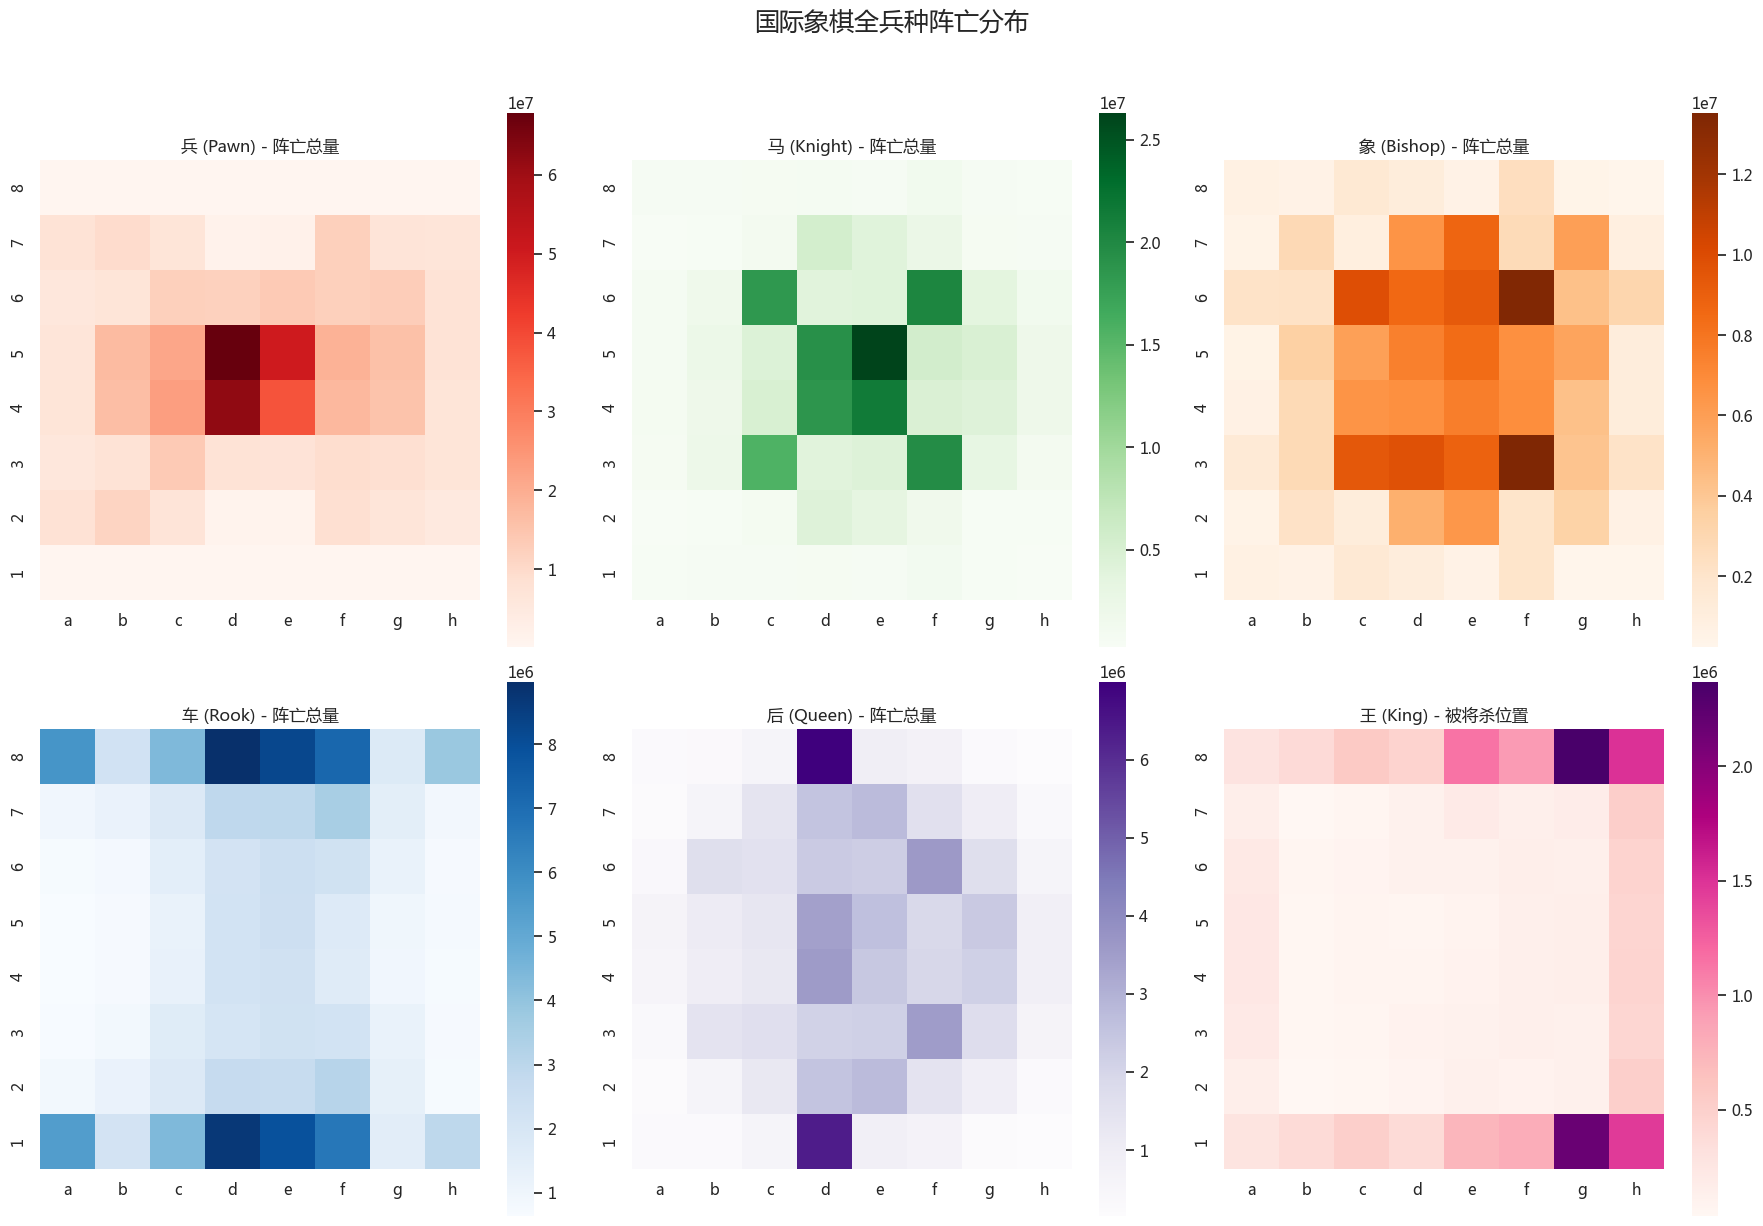

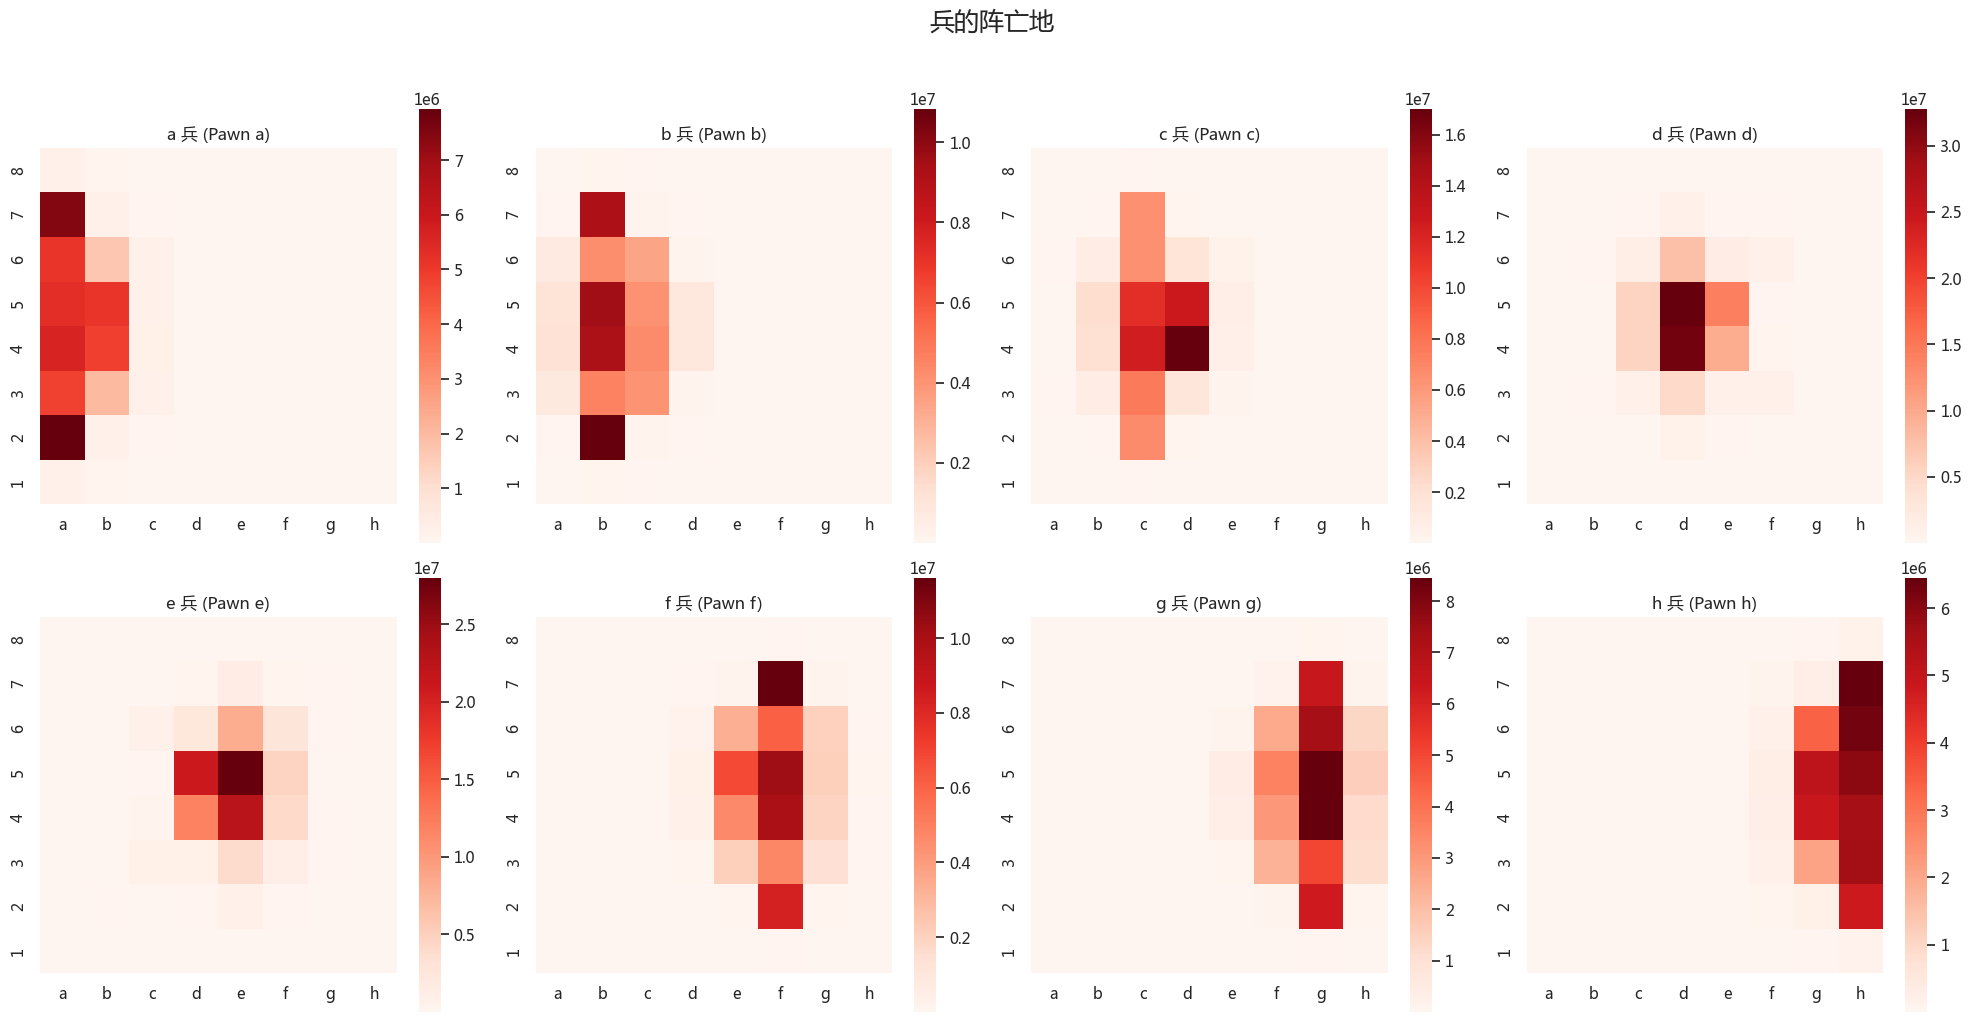

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ================= 配置区域 =================
# 指向 v2 版本的输出文件
JSON_FILE_PATH = "../output/chess_death_map/death_heatmap.json"
# ===========================================

def load_data(filepath):
    if not os.path.exists(filepath):
        print(f"错误：未找到文件 {filepath}")
        return None
    with open(filepath, 'r', encoding='utf-8') as f:
        return json.load(f)

def raw_to_matrix(raw_list):
    """将长度64的list转为8x8矩阵，并进行必要的翻转以适配matplotlib"""
    if not raw_list:
        return np.zeros((8, 8))
    arr = np.array(raw_list).reshape(8, 8)
    return np.flipud(arr) # 翻转，使 Rank 8 在上方

def get_aggregated_heatmap(detailed_data, piece_type):
    """
    智能聚合函数：
    1. 如果是 King/Queen，直接查找 key。
    2. 如果是 Pawn，查找 _All 后缀 (由 C++ 预聚合)。
    3. 如果是 Knight/Bishop/Rook，需要手动遍历并合并 (例如 Knight_b + Knight_g)。
    """
    total_matrix = np.zeros((8, 8))
    
    # 遍历所有 key，找到匹配该兵种的条目并累加
    # 例如 piece_type="Knight"，会匹配 "White_Knight_b", "Black_Knight_g" 等
    for key, val in detailed_data.items():
        if piece_type in key:
            # 排除 Pawn 的具体分列数据，只取 _All 防止重复计算
            # (虽然 C++ 生成了 _All，但也生成了 _a, _b... 如果全加会重复)
            if piece_type == "Pawn" and "All" not in key:
                continue
            
            # 对于其他兵种，累加所有匹配项
            matrix = raw_to_matrix(val)
            total_matrix += matrix
            
    return total_matrix

def plot_heatmap(ax, data, title, cmap):
    if np.sum(data) > 0:
        sns.heatmap(data, ax=ax, cmap=cmap,
                    xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                    yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'],
                    annot=False, square=True, cbar=True)
    else:
        ax.text(0.5, 0.5, "暂无数据", ha='center', va='center', fontsize=12)
        ax.axis('off')
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel("")
    ax.set_ylabel("")

def main():
    # 设置风格
    sns.set(style="whitegrid")
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei','SimHei', 'Arial Unicode MS', 'DejaVu Sans', 'Noto Sans Symbols 2']
    plt.rcParams['axes.unicode_minus'] = False

    data = load_data(JSON_FILE_PATH)
    if not data:
        return
    
    detailed = data["death_heatmaps"]["detailed"]
    total_deaths = data["meta_info"]["total_events"]

    # ==========================================
    # 图表 1: 全兵种阵亡/将杀热力图 (2x3)
    # ==========================================
    fig1, axes1 = plt.subplots(2, 3, figsize=(18, 12))
    axes1 = axes1.flatten()
    
    pieces_config = [
        ("Pawn",   "兵 (Pawn) - 阵亡总量",   "Reds"),
        ("Knight", "马 (Knight) - 阵亡总量", "Greens"),
        ("Bishop", "象 (Bishop) - 阵亡总量", "Oranges"),
        ("Rook",   "车 (Rook) - 阵亡总量",   "Blues"),
        ("Queen",  "后 (Queen) - 阵亡总量",  "Purples"),
        ("King",   "王 (King) - 被将杀位置", "RdPu") 
    ]

    for i, (p_type, title, cmap) in enumerate(pieces_config):
        matrix = get_aggregated_heatmap(detailed, p_type)
        plot_heatmap(axes1[i], matrix, title, cmap)

    fig1.suptitle(f"国际象棋全兵种阵亡分布", fontsize=18, y=1.02)
    plt.tight_layout()
    # fig1.savefig("chess_heatmap_v2_summary.png", bbox_inches='tight', dpi=150)
    print("生成图表 1: chess_heatmap_v2_summary.png")

    # ==========================================
    # 图表 2: 兵的特异性分析 (a-h 兵分别死在哪)
    # ==========================================
    fig2, axes2 = plt.subplots(2, 4, figsize=(20, 10))
    axes2 = axes2.flatten()
    
    files = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    
    for i, f_char in enumerate(files):
        # 聚合该列兵的数据 (White_Pawn_a + Black_Pawn_a)
        key_white = f"White_Pawn_{f_char}"
        key_black = f"Black_Pawn_{f_char}"
        
        mat_w = raw_to_matrix(detailed.get(key_white, []))
        mat_b = raw_to_matrix(detailed.get(key_black, []))
        total_mat = mat_w + mat_b
        
        plot_heatmap(axes2[i], total_mat, f"{f_char} 兵 (Pawn {f_char})", "Reds")

    fig2.suptitle("兵的阵亡地", fontsize=18, y=1.02)
    plt.tight_layout()
    # fig2.savefig("chess_heatmap_v2_pawns.png", bbox_inches='tight', dpi=150)
    print("生成图表 2: chess_heatmap_v2_pawns.png")
    
    plt.show()

if __name__ == "__main__":
    main()

正在计算相对死亡率...
美化完成，图表已保存为: chess_relative_death_rate_beauty.svg


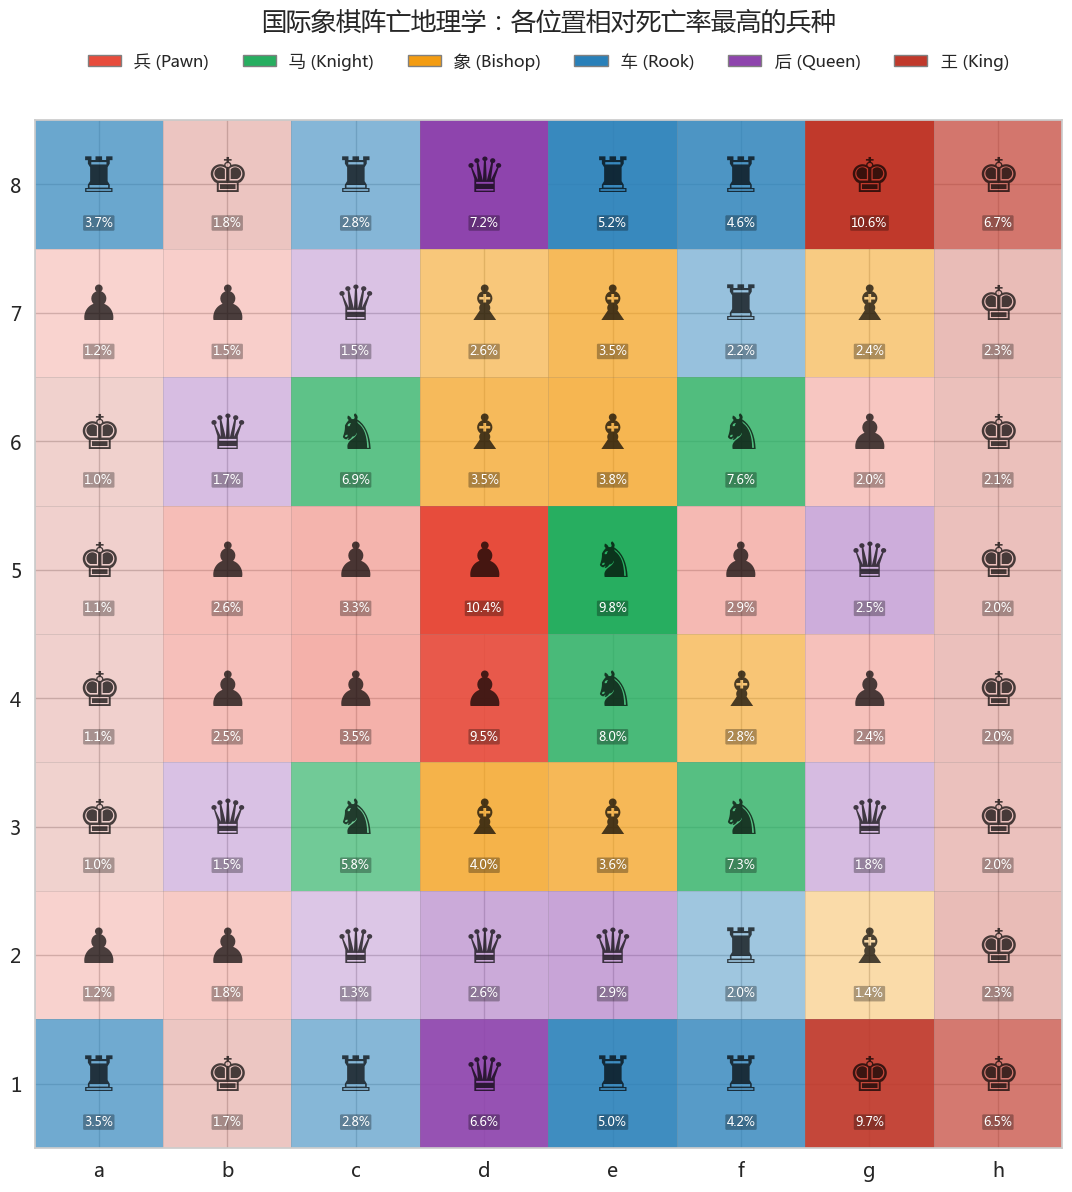

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import seaborn as sns
import os

# ================= 配置区域 =================
JSON_FILE_PATH = "../output/chess_death_map/death_heatmap.json"
OUTPUT_FILE = "chess_relative_death_rate_beauty.svg"
# ===========================================

def load_data(filepath):
    if not os.path.exists(filepath):
        print(f"错误：未找到文件 {filepath}")
        return None
    with open(filepath, 'r', encoding='utf-8') as f:
        return json.load(f)

def raw_to_matrix(raw_list):
    if not raw_list: return np.zeros((8, 8))
    return np.flipud(np.array(raw_list).reshape(8, 8))

def get_aggregated_matrix(detailed_data, piece_type):
    total_matrix = np.zeros((8, 8))
    for key, val in detailed_data.items():
        if piece_type in key:
            if piece_type == "Pawn" and "All" not in key: continue
            total_matrix += raw_to_matrix(val)
    return total_matrix

def main():
    # 1. 准备数据
    data = load_data(JSON_FILE_PATH)
    if not data: return
    detailed = data["death_heatmaps"]["detailed"]
    
    # 定义兵种配置：名称、图标、基础颜色
    piece_config = [
        {"key": "Pawn",   "icon": "♟", "color": "#e74c3c", "label": "兵 (Pawn)"},   # 红
        {"key": "Knight", "icon": "♞", "color": "#27ae60", "label": "马 (Knight)"}, # 绿
        {"key": "Bishop", "icon": "♝", "color": "#f39c12", "label": "象 (Bishop)"}, # 橙
        {"key": "Rook",   "icon": "♜", "color": "#2980b9", "label": "车 (Rook)"},   # 蓝
        {"key": "Queen",  "icon": "♛", "color": "#8e44ad", "label": "后 (Queen)"},  # 紫
        {"key": "King",   "icon": "♚", "color": "#c0392b", "label": "王 (King)"}    # 深红
    ]
    
    # 计算相对死亡率
    maps = {}
    max_rate_global = 0 # 用于全局归一化透明度
    
    print("正在计算相对死亡率...")
    for p in piece_config:
        mat = get_aggregated_matrix(detailed, p["key"])
        total = np.sum(mat)
        if total > 0:
            rate_mat = mat / total
            maps[p["key"]] = rate_mat
            max_rate_global = max(max_rate_global, np.max(rate_mat))
        else:
            maps[p["key"]] = np.zeros((8, 8))

    # 2. 绘图设置
    # 使用无衬线字体以更好支持 Unicode，或者指定具体的字体如 'DejaVu Sans'
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei','SimHei', 'Arial Unicode MS', 'DejaVu Sans', 'Noto Sans Symbols 2']
    plt.rcParams['axes.unicode_minus'] = False
    
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_aspect('equal')
    
    # 绘制棋盘网格
    ax.set_xlim(0, 8)
    ax.set_ylim(0, 8)
    ax.set_xticks(np.arange(0.5, 8.5, 1))
    ax.set_yticks(np.arange(0.5, 8.5, 1))
    ax.set_xticklabels(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'], fontsize=14)
    ax.set_yticklabels(['1', '2', '3', '4', '5', '6', '7', '8'], fontsize=14)
    ax.tick_params(left=False, bottom=False)
    
    # 画格子边框
    for x in range(9):
        ax.axvline(x, color='gray', linewidth=0.5, alpha=0.3)
        ax.axhline(x, color='gray', linewidth=0.5, alpha=0.3)

    # 3. 核心绘制循环
    rows, cols = 8, 8
    # 我们之前的逻辑是 Rank 8 在矩阵上方 (row 0)，但在 plot 中 y=0 是底部
    # 所以需要注意坐标转换。
    # 之前 raw_to_matrix 做了 flipud，所以 row 0 是 Rank 8 (y=7.5)，row 7 是 Rank 1 (y=0.5)
    
    for r in range(rows):     # r: 0 (Rank 8) -> 7 (Rank 1)
        for c in range(cols): # c: 0 (File a) -> 7 (File h)
            
            # 找出该格子概率最高的兵种
            best_p = None
            max_val = -1.0
            
            for p in piece_config:
                rate = maps[p["key"]][r, c]
                if rate > max_val:
                    max_val = rate
                    best_p = p
            
            if max_val <= 0: continue
            
            # 坐标转换：
            # r=0 -> y=7 (Rank 8), r=7 -> y=0 (Rank 1)
            y_pos = 7 - r
            x_pos = c
            
            # --- 视觉处理 ---
            
            # 1. 计算透明度 (Alpha)
            # 逻辑：相对于该兵种在全盘的最大概率，或者相对于全局最大概率
            # 建议：为了让低概率的格子也能看清，设置一个底限 (比如 0.15)
            # 这里的 scaling_factor 可以调节对比度
            scaling = max_val / maps[best_p["key"]].max() 
            alpha = 0.15 + 0.85 * scaling 
            alpha = min(1.0, alpha)

            # 2. 绘制背景色块
            base_rgba = to_rgba(best_p["color"])
            final_color = (base_rgba[0], base_rgba[1], base_rgba[2], alpha)
            
            rect = patches.Rectangle((x_pos, y_pos), 1, 1, linewidth=0, facecolor=final_color)
            ax.add_patch(rect)
            
            # 3. 绘制图标和文字
            # 只有当透明度足够高（即概率显著）时，才画图标，避免杂乱
            if alpha > 0.2:
                # 绘制棋子图标 (大)
                ax.text(x_pos + 0.5, y_pos + 0.55, best_p["icon"], 
                        ha='center', va='center', fontsize=35, color='black', alpha=0.7, fontname='DejaVu Sans')
                
                # 绘制概率数值 (小)
                ax.text(x_pos + 0.5, y_pos + 0.2, f"{max_val:.1%}", 
                        ha='center', va='center', fontsize=9, color='white', fontweight='bold',
                        bbox=dict(facecolor='black', alpha=0.3, edgecolor='none', boxstyle='round,pad=0.1'))

    # 4. 添加自定义图例
    legend_elements = [
        patches.Patch(facecolor=p["color"], edgecolor='gray', label=p["label"])
        for p in piece_config
    ]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.08),
              ncol=6, frameon=False, fontsize=12)

    ax.set_title("国际象棋阵亡地理学：各位置相对死亡率最高的兵种", fontsize=18, y=1.08, fontweight='bold')
    
    plt.tight_layout()
    # plt.savefig(OUTPUT_FILE, dpi=150, bbox_inches='tight')
    plt.savefig(OUTPUT_FILE, bbox_inches='tight')
    print(f"美化完成，图表已保存为: {OUTPUT_FILE}")
    plt.show()

if __name__ == "__main__":
    main()

已保存: heatmap_full_white.svg
已保存: heatmap_full_black.svg


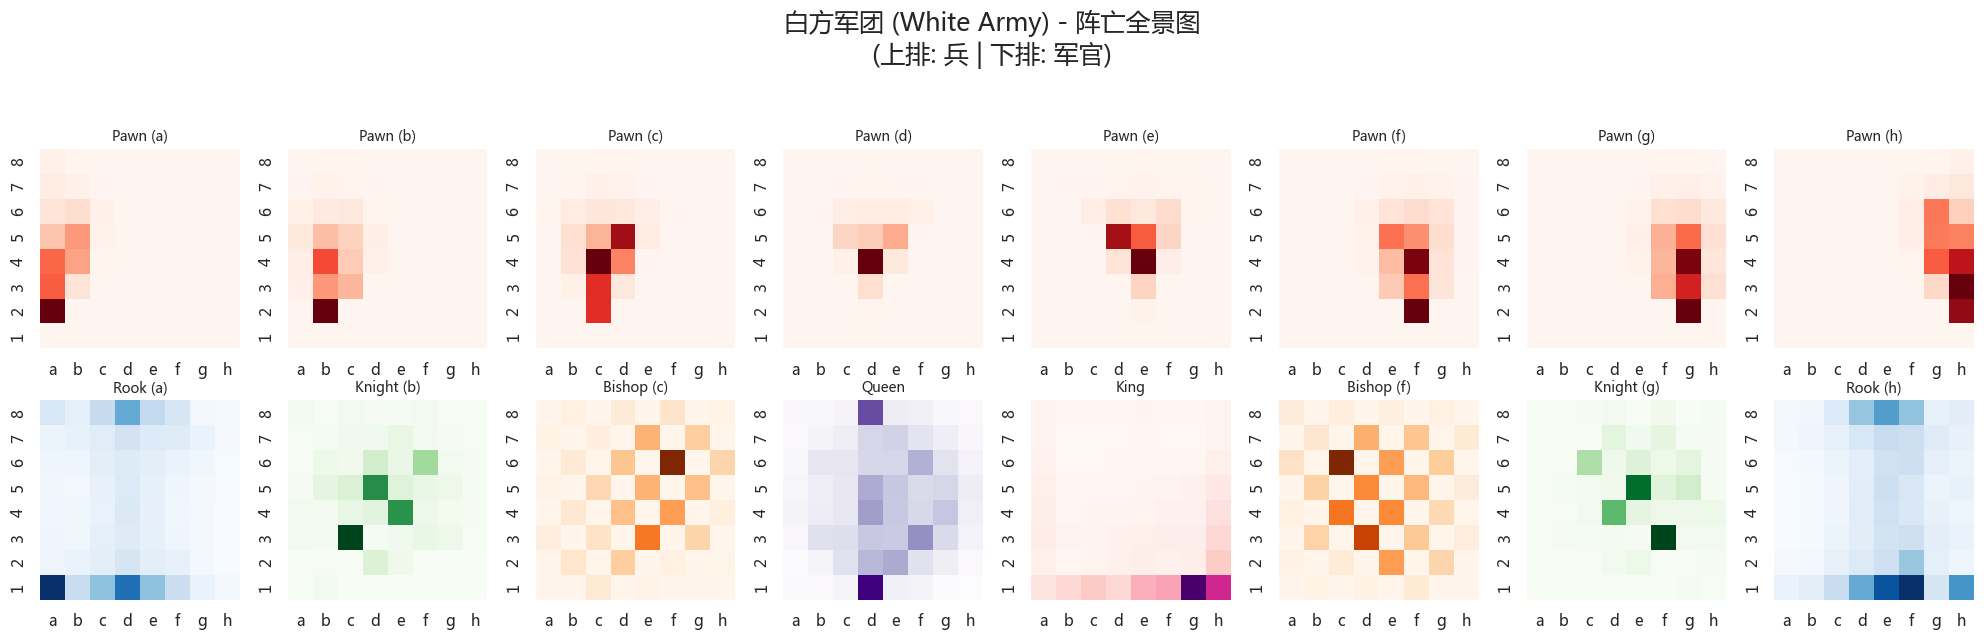

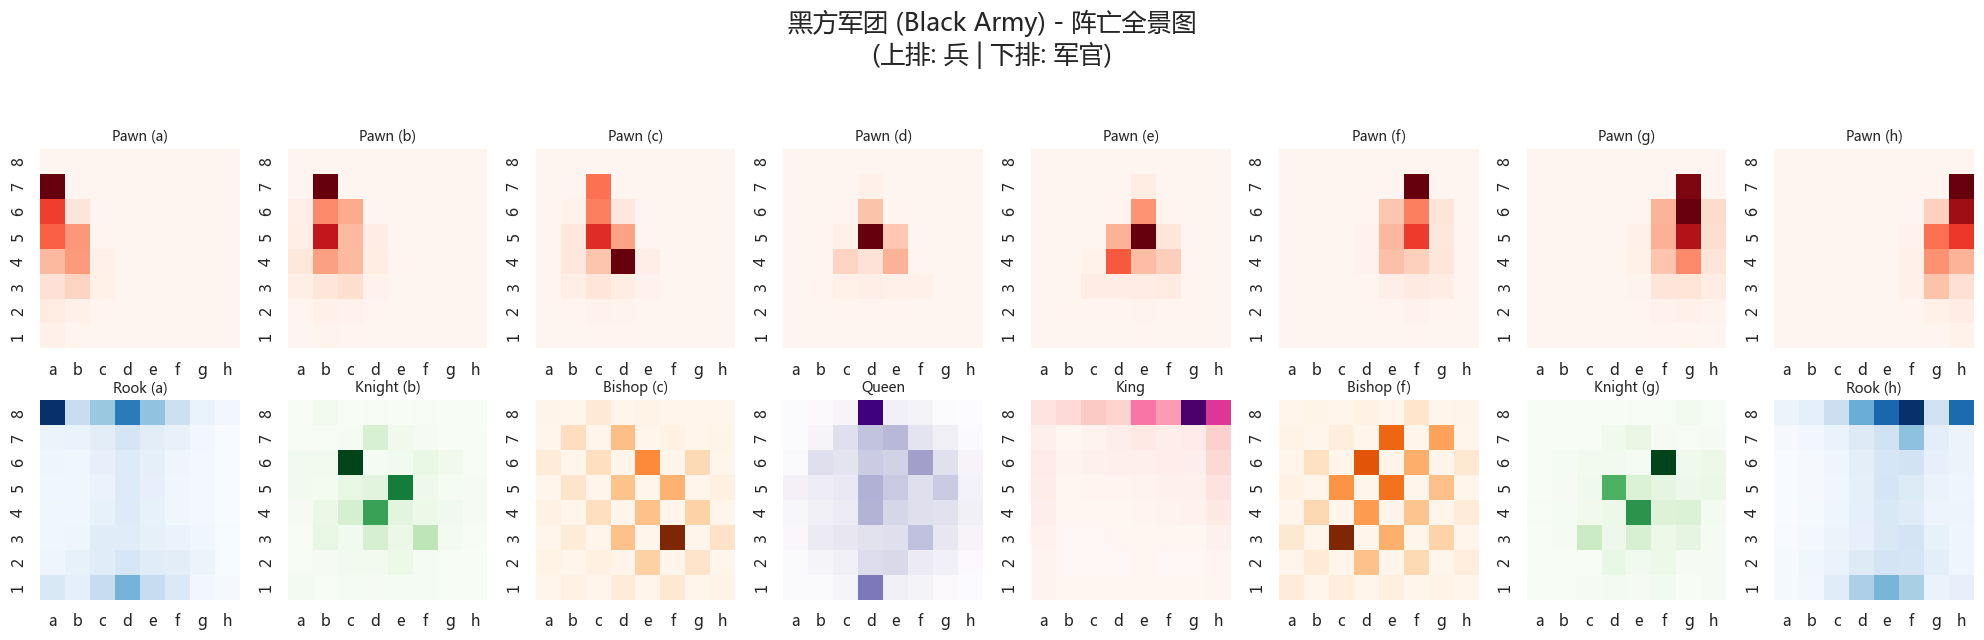

In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ================= 配置区域 =================
JSON_FILE_PATH = "../output/chess_death_map/death_heatmap.json"
# ===========================================

def load_data(filepath):
    if not os.path.exists(filepath):
        print(f"错误：未找到文件 {filepath}")
        return None
    with open(filepath, 'r', encoding='utf-8') as f:
        return json.load(f)

def raw_to_matrix(raw_list):
    """将list转为8x8矩阵，并翻转以适配matplotlib"""
    if not raw_list:
        return np.zeros((8, 8))
    arr = np.array(raw_list).reshape(8, 8)
    return np.flipud(arr) # Rank 8 在上方

def plot_single_heatmap(ax, data, title, color_map):
    if np.sum(data) > 0:
        sns.heatmap(data, ax=ax, cmap=color_map,
                    xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                    yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'],
                    annot=False, square=True, cbar=False) # 关闭cbar以节省空间
    else:
        ax.text(0.5, 0.5, "暂无数据", ha='center', va='center', fontsize=10, color='gray')
        ax.axis('off')
    
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(left=False, bottom=False)

def visualize_army(data, color_prefix, fig_title, output_filename):
    """
    绘制单方军团的 16 个热力图
    布局：
    Row 1: 后排棋子 (R-N-B-Q-K-B-N-R)
    Row 2: 8个兵 (a-h)
    """
    detailed = data["death_heatmaps"]["detailed"]
    
    # 定义绘图顺序和配色
    # (Key后缀, 显示名称, 色系)
    # 注意：C++代码中 Queen/King 没有后缀，R/N/B 有 _a, _b 等后缀
    
    # 后排棋子顺序 (从 a 到 h)
    back_rank_structure = [
        (f"{color_prefix}_Rook_a",   "Rook (a)",   "Blues"),
        (f"{color_prefix}_Knight_b", "Knight (b)", "Greens"),
        (f"{color_prefix}_Bishop_c", "Bishop (c)", "Oranges"),
        (f"{color_prefix}_Queen",     "Queen",      "Purples"),
        (f"{color_prefix}_King",      "King",       "RdPu"),
        (f"{color_prefix}_Bishop_f", "Bishop (f)", "Oranges"),
        (f"{color_prefix}_Knight_g", "Knight (g)", "Greens"),
        (f"{color_prefix}_Rook_h",   "Rook (h)",   "Blues"),
    ]
    
    # 兵的顺序 (a 到 h)
    pawns_structure = [
        (f"{color_prefix}_Pawn_{f}", f"Pawn ({f})", "Reds") for f in ['a','b','c','d','e','f','g','h']
    ]
    
    # 合并列表：先画兵(放在上方或下方? 习惯上棋盘兵在前方)
    # 让我们把兵画在上面一行，后排画在下面一行 (符合白棋视角)
    # 或者为了图表整洁，第一行画兵，第二行画后排
    all_pieces = pawns_structure + back_rank_structure
    
    # 创建画布 4行4列 (虽然是2x8，但4x4更方正适合屏幕) 
    # 或者 2行8列 (比较宽) -> 建议 4x4
    # 这里我们用 2行8列 模拟棋盘展开
    fig, axes = plt.subplots(2, 8, figsize=(20, 6))
    axes = axes.flatten()
    
    for i, (key, name, cmap) in enumerate(all_pieces):
        raw_data = detailed.get(key, [])
        matrix = raw_to_matrix(raw_data)
        plot_single_heatmap(axes[i], matrix, name, cmap)

    fig.suptitle(fig_title, fontsize=18, y=1.05)
    plt.tight_layout()
    plt.savefig(output_filename, bbox_inches='tight', dpi=150)
    print(f"已保存: {output_filename}")

def main():
    # 风格设置
    sns.set(style="white")
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei','SimHei', 'Arial Unicode MS', 'DejaVu Sans', 'Noto Sans Symbols 2']
    plt.rcParams['axes.unicode_minus'] = False

    data = load_data(JSON_FILE_PATH)
    if not data:
        return

    # 1. 绘制白方军团
    visualize_army(
        data, 
        "White", 
        "白方军团 (White Army) - 阵亡全景图\n(上排: 兵 | 下排: 军官)", 
        "heatmap_full_white.svg"
    )

    # 2. 绘制黑方军团
    visualize_army(
        data, 
        "Black", 
        "黑方军团 (Black Army) - 阵亡全景图\n(上排: 兵 | 下排: 军官)", 
        "heatmap_full_black.svg"
    )
    
    plt.show()

if __name__ == "__main__":
    main()